### **Step 1: Project Overview**

In this project, I built a complete end-to-end MLOps system for forecasting daily taxi demand on Google Cloud.
This work is actually the continuation of my previous project, where I trained a forecasting model directly in BigQuery ML using the ARIMA_PLUS algorithm.

In that earlier project, the focus was mostly on the data science side: exploring the data, training the model, and understanding the results. I turned that model into a production-ready MLOps pipeline and API.

So instead of just having a model inside BigQuery, I now have:
- Modular business logic in Python for loading data, training the model, and evaluating it
- Reusable, parameterized pipelines using Vertex AI Pipelines (KFP v2)
- A BigQuery ML ARIMA_PLUS model that is trained and evaluated automatically through the pipeline
- Cloud Storage that stores pipeline artifacts, logs, and metadata
- A Dockerized FastAPI service that talks to BigQuery ML and serves forecasts
- And finally, a fully managed Cloud Run deployment that exposes the model as a live HTTP API with a small web UI

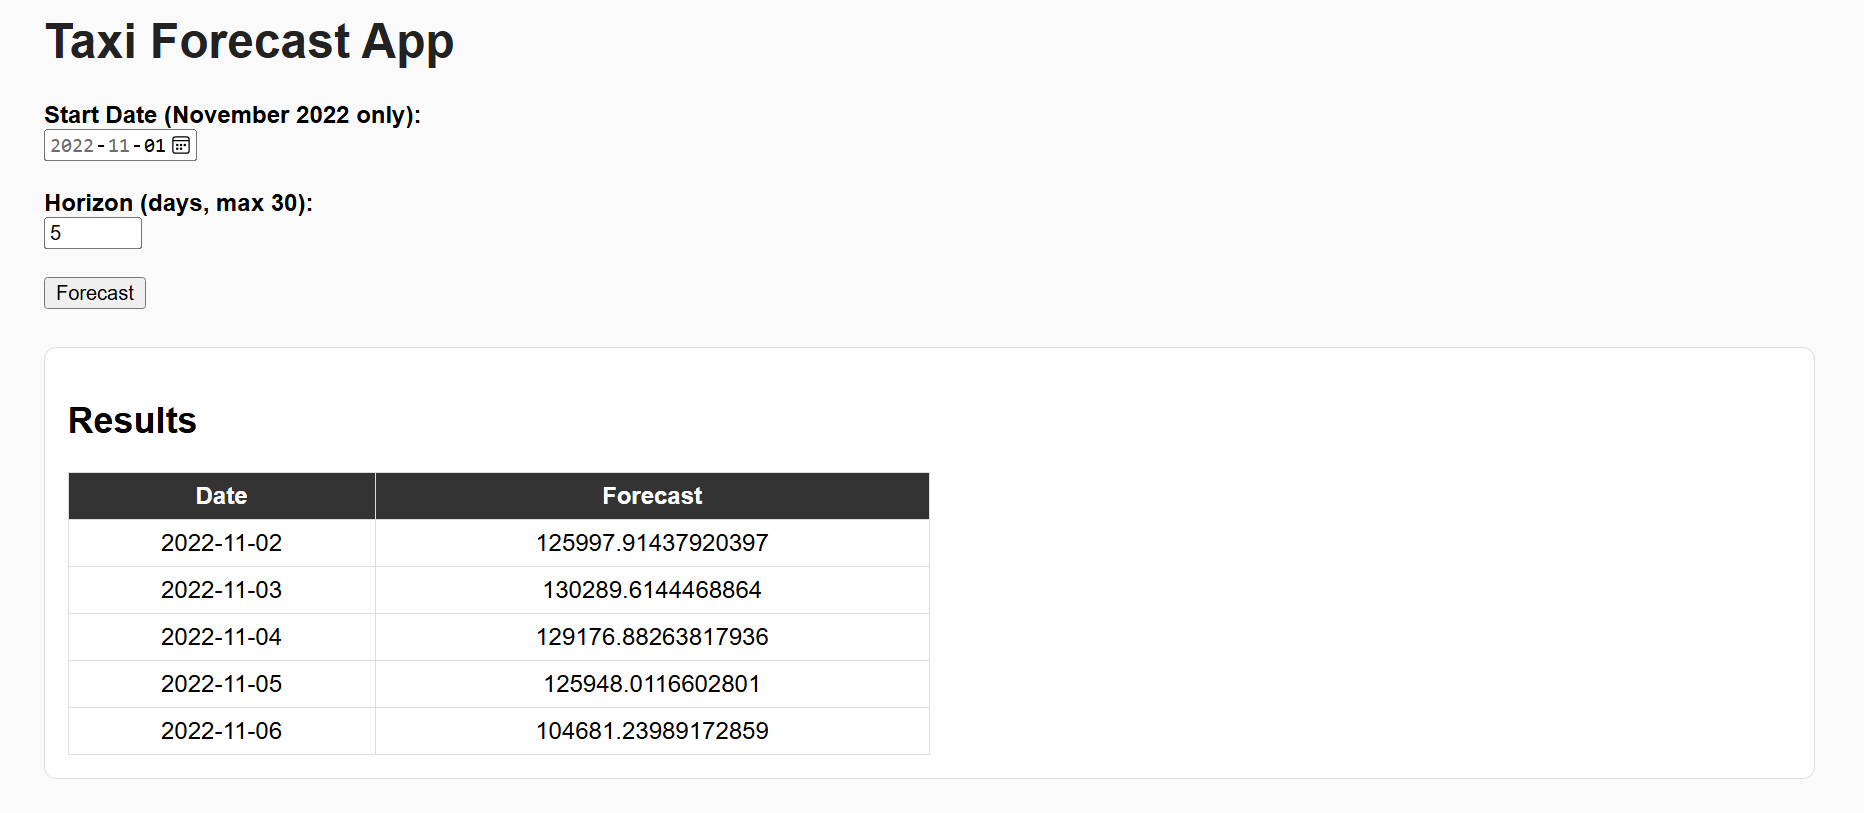

The main idea of the project is "Start from raw data in BigQuery → automatically train and evaluate a model → and then expose predictions through a scalable API on Google Cloud".

So this is not just a model demo anymore.  It’s a full MLOps flow that shows how I go from:
- data
- to pipelines
- to model registry
- to Docker image
- to a real, production-style API endpoint.

### **Step 2: Environment Setup**

Before building any pipelines or APIs, the very first thing I did was setting up a clean, isolated Python environment. In MLOps projects, dependency management is extremely important.
 Different tools—like Kubeflow Pipelines, BigQuery SDK, FastAPI, and Google client libraries—each require specific versions.
 If we install everything directly on the system Python, it becomes messy very quickly and can break other projects.

In [ ]:
python3.10 -m venv venv-kfp2
venv-kfp2\Scripts\activate

Here’s why this step matters:
- Isolation of Dependencies
- Reproducibility
- Clean MLOps Workflow

This setup is especially important when using KFP v2, because the pipeline compiler must detect and package the correct Python functions.

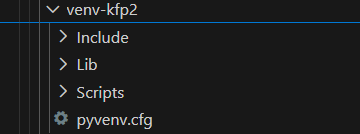

### **Step 3: Business Logic Components**

Before I even touched Vertex AI Pipelines, I built and tested all the business logic components separately. This step is critical in any real MLOps workflow. The business logic process in this project guarantees:
- The BigQuery project & dataset paths are correct
- Your SQL queries run
- Permissions (ADC) are correct
- Imports work
- Inputs & outputs behave as expected

Because once this logic is verified, we can wrap them into pipeline components with confidence. Otherwise, the whole system fails on Vertex AI and debugging takes hours.

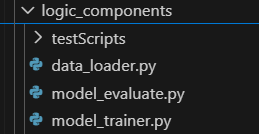

### **Step 4: Vertex AI Pipeline Development (KFP v2)**

After we validated all business logic, the next step was to convert those functions into full production-grade MLOps pipelines using Vertex AI Pipelines (KFP v2). This phase has one goal “Turn raw Python logic into reusable pipeline components and then connect them into a complete DAG.”

Each stage of the ML workflow needed its own independent pipeline:

**Data Loader Pipeline**
- Reads the BigQuery source table  
- Splits data into train/test BigQuery tables  
- Ensures consistent cutoff date for reproducibility  

**Train Model Pipeline**
- Uses BigQuery ML `ARIMA_PLUS`  
- Builds and saves a time-series forecasting model  

**Evaluation Pipeline**
- Reads the trained model  
- Calculates the AIC score  
- Returns a numeric output  


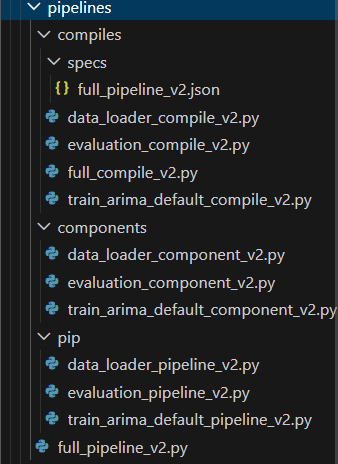

Each pipeline followed the same 3-file structure, based on Google’s recommended pattern:

**1) Component File (business logic container)**
This wraps the logic into a reusable KFP component.
- Defines the Docker image used  
- Specifies install dependencies  
- Accepts inputs & returns outputs  
- Runs small Python code in a controlled environment  

**2) Pipeline File (DAG definition)**
This connects components into a logical sequence.
- Each step depends on the previous step  
- Output from one step is passed to the next 

**3) Compile File (export JSON spec)****
Vertex AI doesn’t read YAML for v2 pipelines.
- We compile the pipeline into a **JSON spec file**  
- This JSON is uploaded or referenced by Vertex AI Pipelines  


Once all individual tasks were validated, the full pipeline was assembled.
- Combines all components into one **directed acyclic graph (DAG)**  
- This is the actual production pipeline that Vertex AI executes end-to-end  
- After building the full DAG, we **generate a JSON spec**  
- The JSON spec becomes the **single artifact representing the entire MLOps workflow**  

### **Step 5: Running Pipelines in Vertex AI**

#### **5.1: Create Bucket in Google Storage**

Before running any pipeline inside Vertex AI, we needed a storage location for all pipeline artifacts. Vertex AI Pipelines always writes logs, intermediate files, and metadata into a **Google Cloud Storage (GCS) bucket**.

Every pipeline run generates:
- Execution logs  
- Metadata for each component  
- Step inputs & outputs  
- Cached results  
- System-generated JSON/YAML configs  

If no bucket is specified, the pipeline cannot run. Why This Matters for MLOps? because:
- Ensures full traceability  
- Supports reproducibility  
- Stores logs for debugging & monitoring  
- Enables versioning of pipeline runs over time  

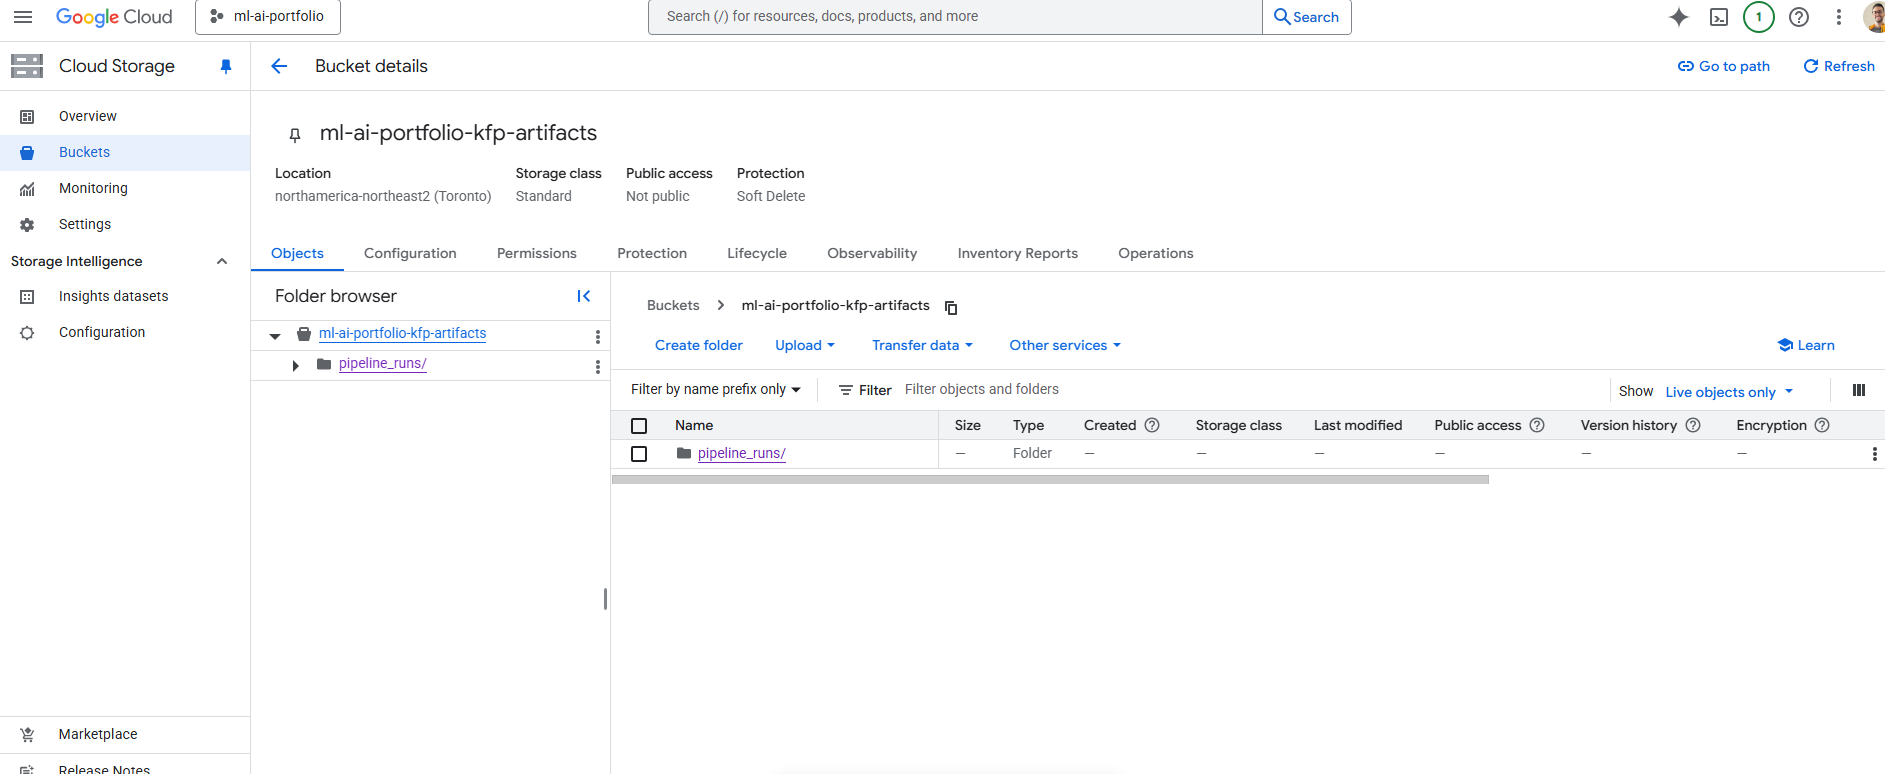

#### **5.2: Create Service Account in IAM**

To run a full MLOps pipeline on Google Cloud, Vertex AI must have proper permissions to access required services. A pipeline interacts with:
- Cloud Storage  
- BigQuery  
- Vertex AI Pipelines  
- BigQuery ML (model training + forecasting)  

Thus, we configured a dedicated service account that Vertex AI Pipelines uses to execute each component. This service account must be authorized to:
- Read & write to the pipeline artifact bucket  
- Read & write to BigQuery (ARIMA training + queries)  
- Execute workflows in Vertex AI  

If these permissions are missing, the pipeline will fail immediately.  

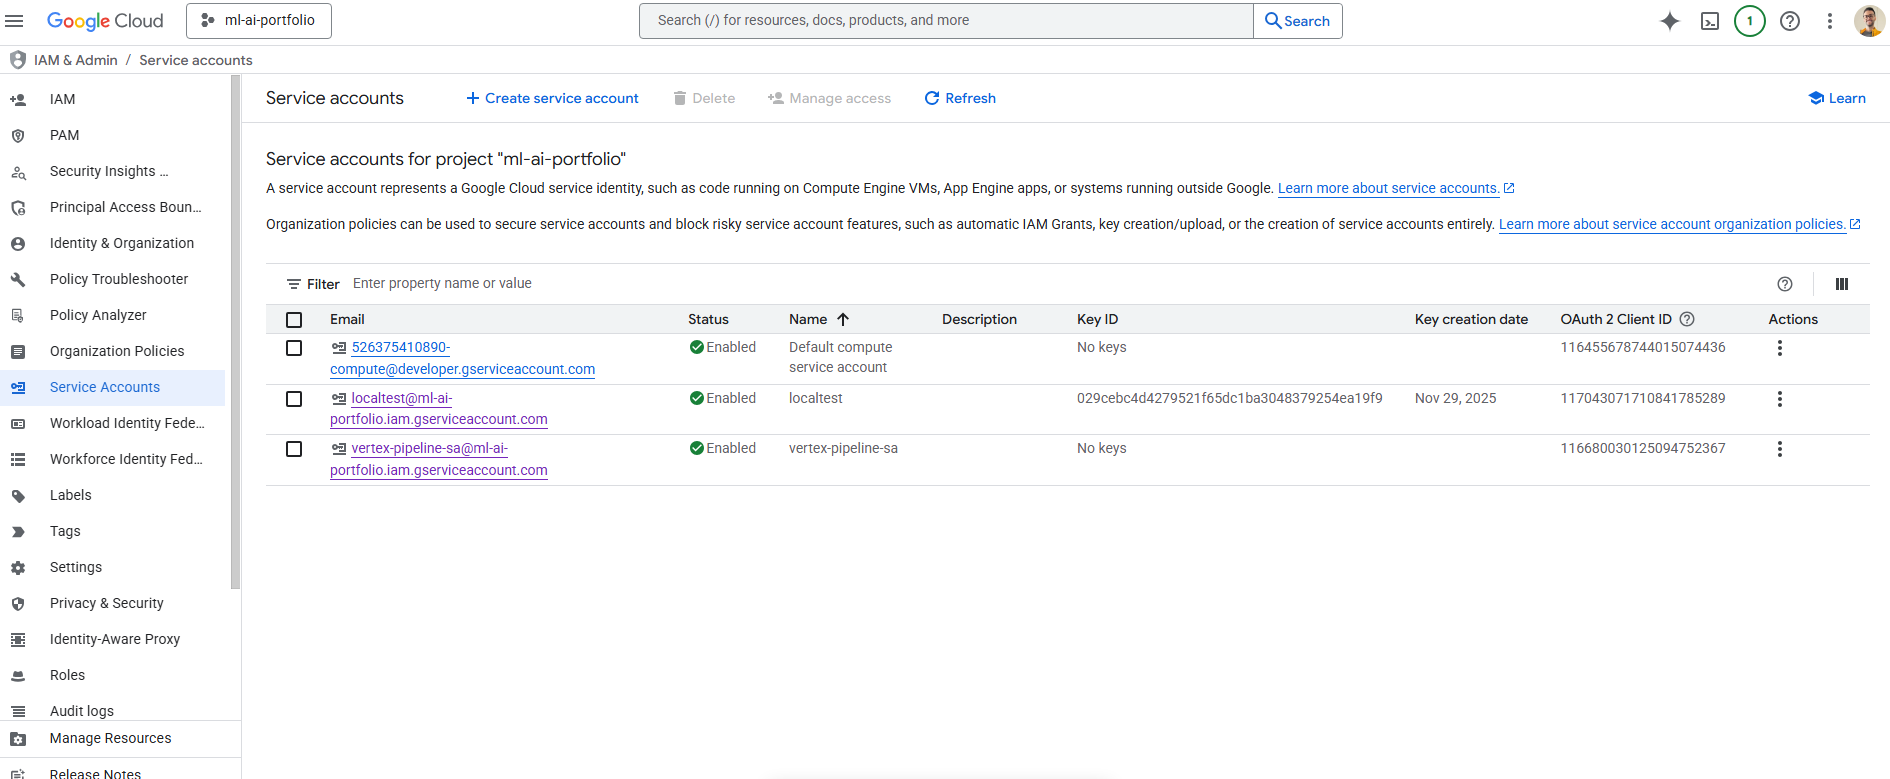

#### **5.3: Run Pipeline in Vertex AI**

Once all individual tasks were validated, the full pipeline was created. This combined every component into one Directed Acyclic Graph (DAG):
- This is the real **production pipeline** that Vertex AI runs end-to-end  
- All upstream components (Data Loader, Trainer, Evaluator) flow together  
- Outputs from one step become inputs to the next  

After defining the full pipeline, we **compiled it into a JSON spec file**:
- Vertex AI Pipelines only accepts JSON for v2  
- This single JSON file represents the **entire MLOps workflow**  
- It’s the artifact used to run real automated pipelines inside GCP  

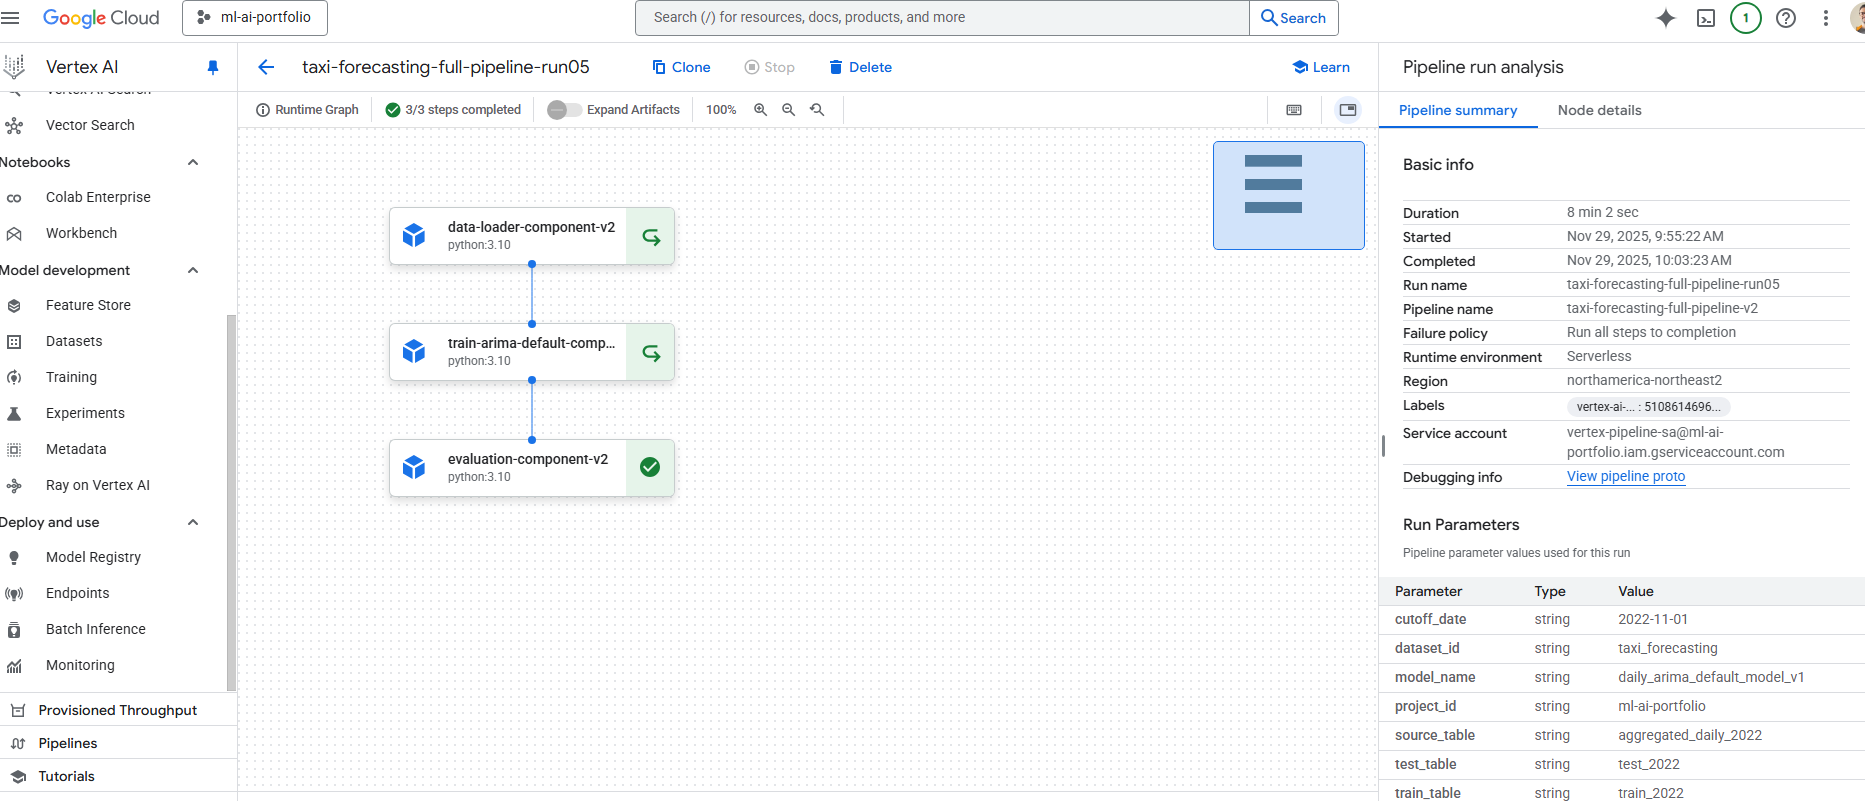

#### **5.4: Check Result in Google Storage Bucket**

Each component produces its own logs.

- Data Loader logs: “Created TRAIN & TEST tables successfully”
- Model Trainer logs: “BigQuery ML model created successfully…”
- Evaluation logs: Printed AIC values


After the pipeline finished:

- Logs validated that all business logic executed correctly  
- Outputs were written to the artifact bucket  
- In BigQuery Console, the ARIMA model was successfully created 

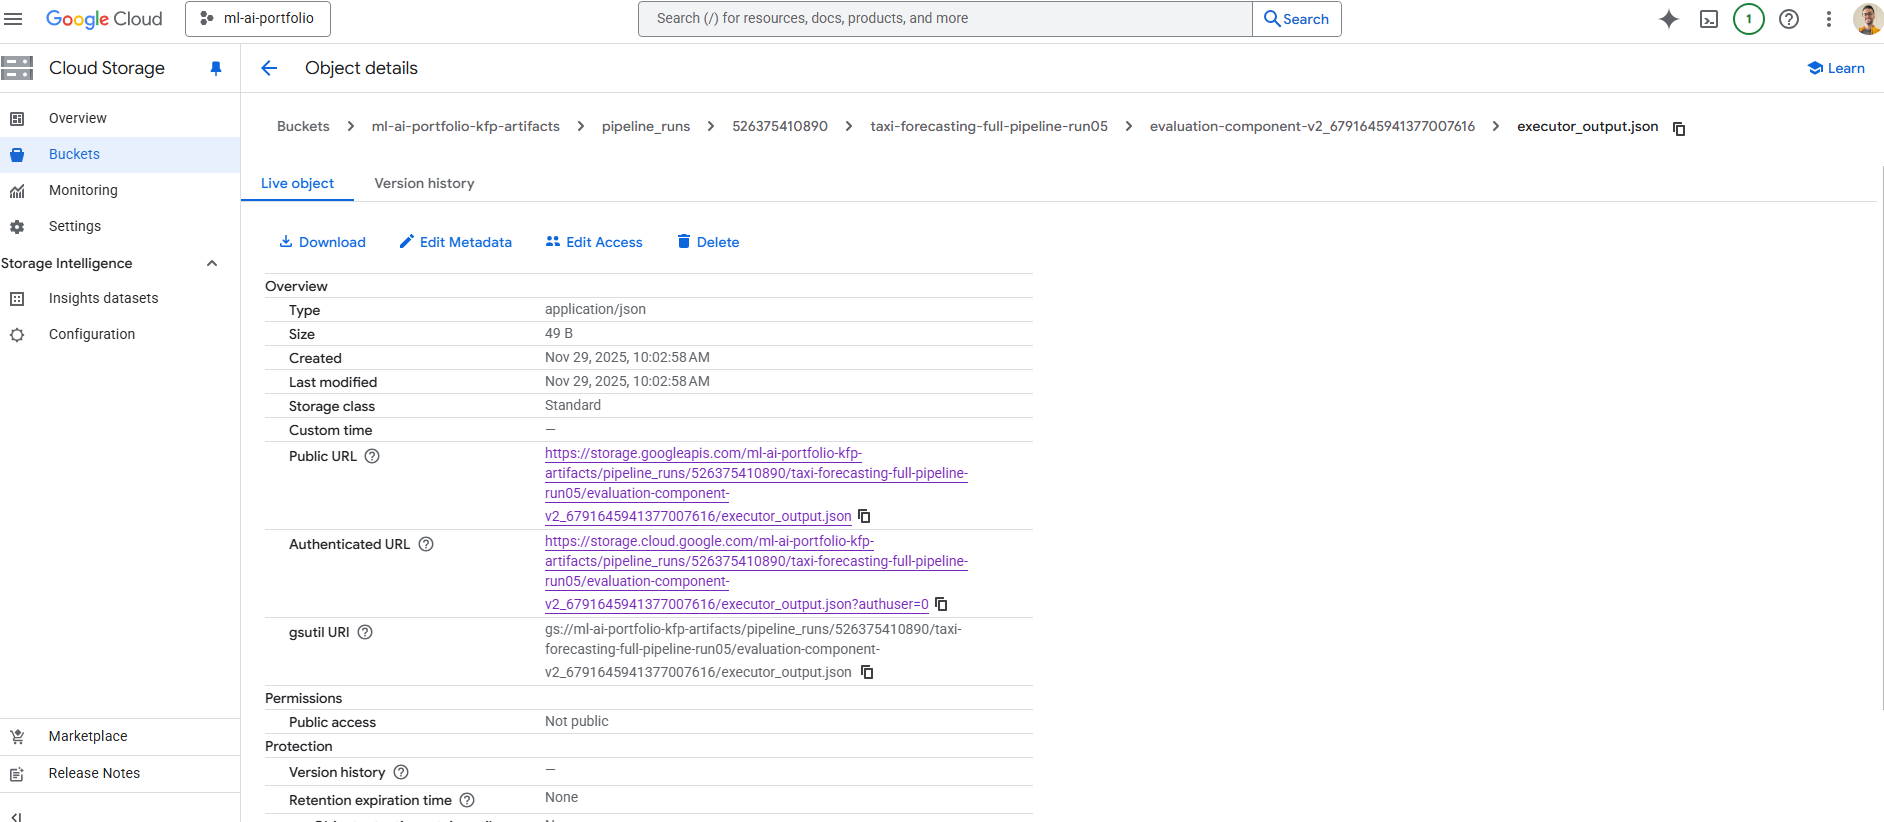

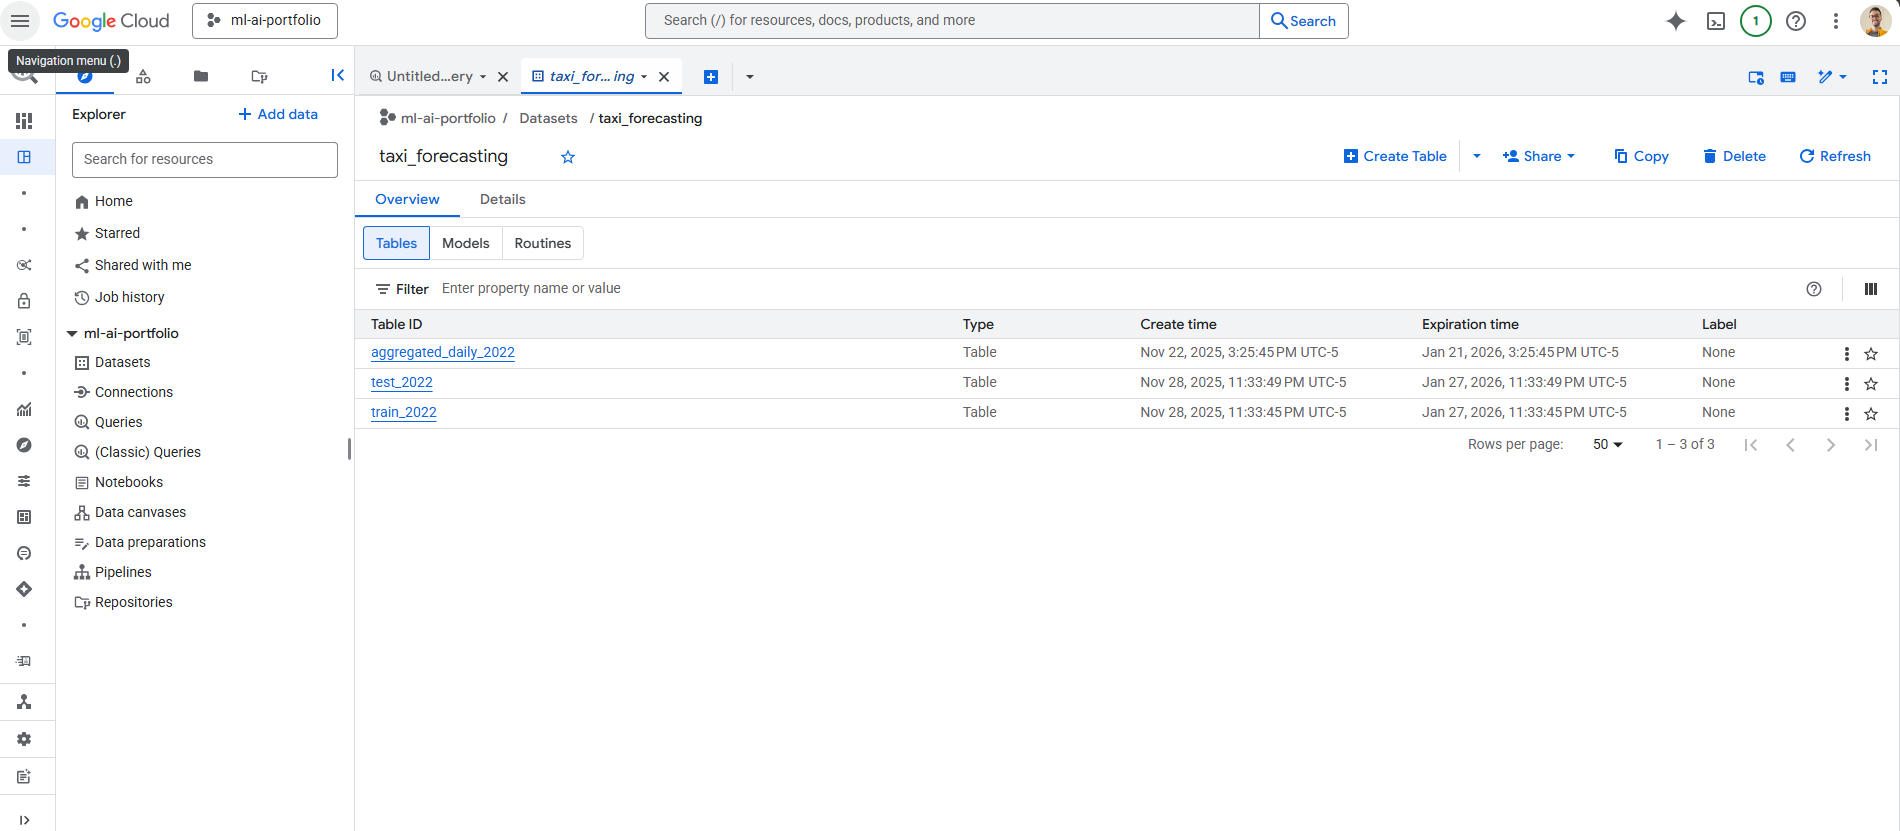

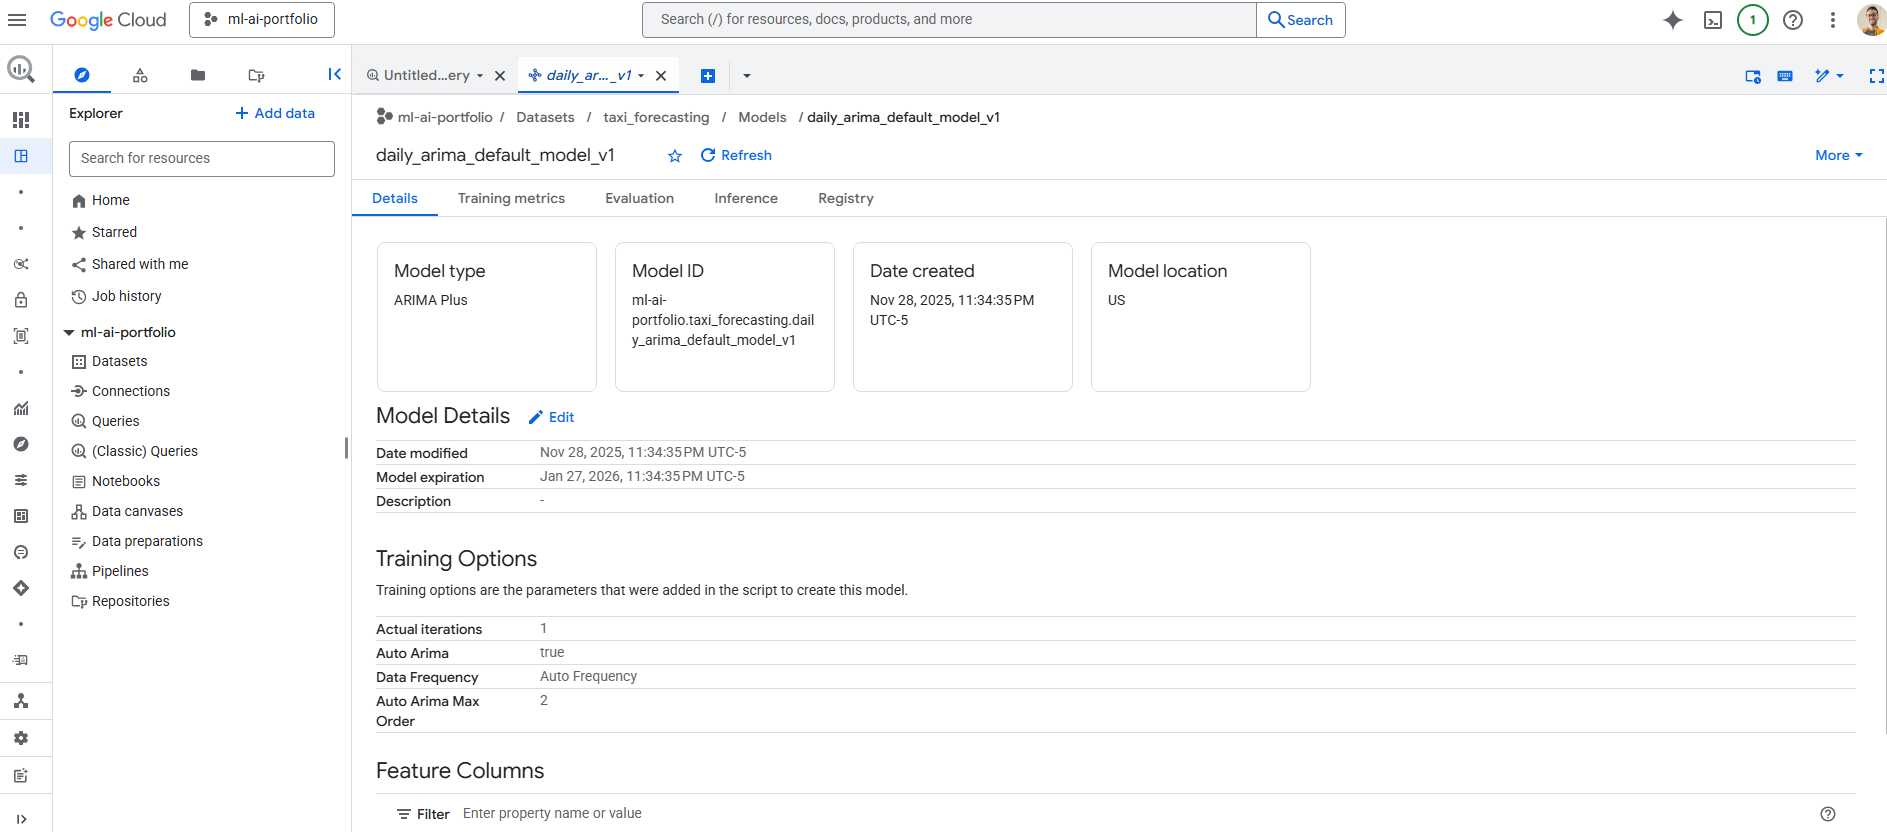

### **Step 6: API Development (FastAPI + Docker)**

#### **6.1: Create structure of Application**

After the pipeline successfully executed inside Vertex AI and the ARIMA model was trained in BigQuery ML, the next phase was **API Development**—converting the trained model into a production-ready service. BigQuery ML stores the model internally, but:

- End users cannot run SQL queries  
- Applications require a REST API  
- Inputs must be validated  
- Outputs must be returned in clean JSON format  

So the goal was to transform: A raw ML model → into a real, callable API service. This file contains the core computation layer. It handles:

- Input validation  
- Ensuring the requested forecast date is inside the model’s training range  
- Connecting to BigQuery  
- Executing `ML.FORECAST`  
- Converting results into a clean JSON-friendly list  
- Returning forecast statistics  

This design keeps the API thin and pushes all business logic into a reusable module.

To demonstrate the model visually and interactively, a small UI was built with:
- A date picker to choose forecast start date  
- A horizon selector  
- A button to trigger API calls  
- A clean results table  
- Error handling  
- Loading animations  

This provides a simple and user-friendly interface for running forecasts without writing SQL.

#### **6.2: Create Requirement File**

Before containerizing the API and deploying it to Cloud Run, I needed to ensure the environment was fully reproducible.  This is where the `requirements.txt` file becomes essential. In machine learning projects — especially full MLOps workflows — **reproducibility** is critical.

Why a requirements file matters? because
- When deploying to Cloud Run, your **local environment does not exist**  
- Cloud Run installs **only** the packages listed inside `requirements.txt`  
- Missing or inconsistent dependencies will cause **container startup failures**

Creating a precise and clean `requirements.txt` is a **foundational prerequisite** before moving into Dockerization and production deployment.

#### **6.3: Create Dockerfile**

After preparing the requirements file, the next major step was to **containerize the API**.  This is a key part of the MLOps lifecycle, because **Cloud Run only deploys applications that run inside a Docker container**. A **Dockerfile** defines exactly how the application should be built:

- Which Python version to use  
- Which system libraries are needed  
- Which Python packages must be installed  
- How to copy and run the FastAPI app  
- Which port the service will listen on  


#### **6.4: Build Image and Run in Local**

Once the Dockerfile was ready, the next critical step was to **build the container image locally** and confirm that the entire API behaved exactly as expected.  This is a standard best-practice in MLOps — we always validate locally **before** pushing anything to the cloud.

I used Docker to create a full local image of the FastAPI service. After the image was built, I ran it locally to validate functionality end-to-end.
Local testing is important, because:

- The application behaves identically inside a container  
- All dependencies are installed correctly  
- Authentication to BigQuery works  
- The HTML interface renders as expected  
- The API responds consistently  
- There are no missing libraries or runtime errors  

By validating everything locally first, I guaranteed that deployment to **Cloud Run** would be smooth and free of surprises.

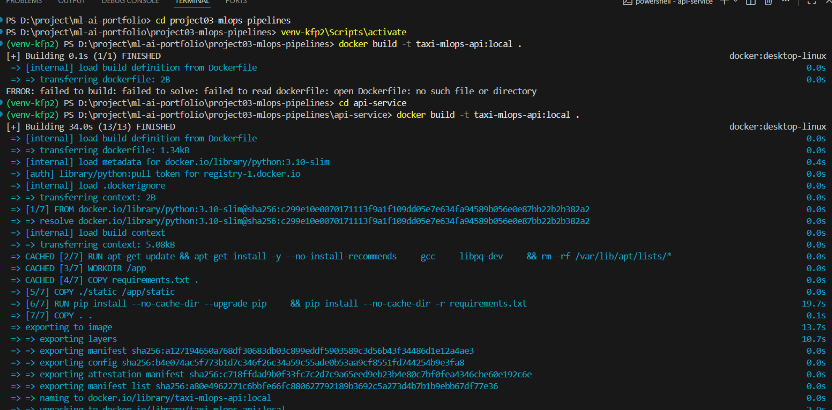

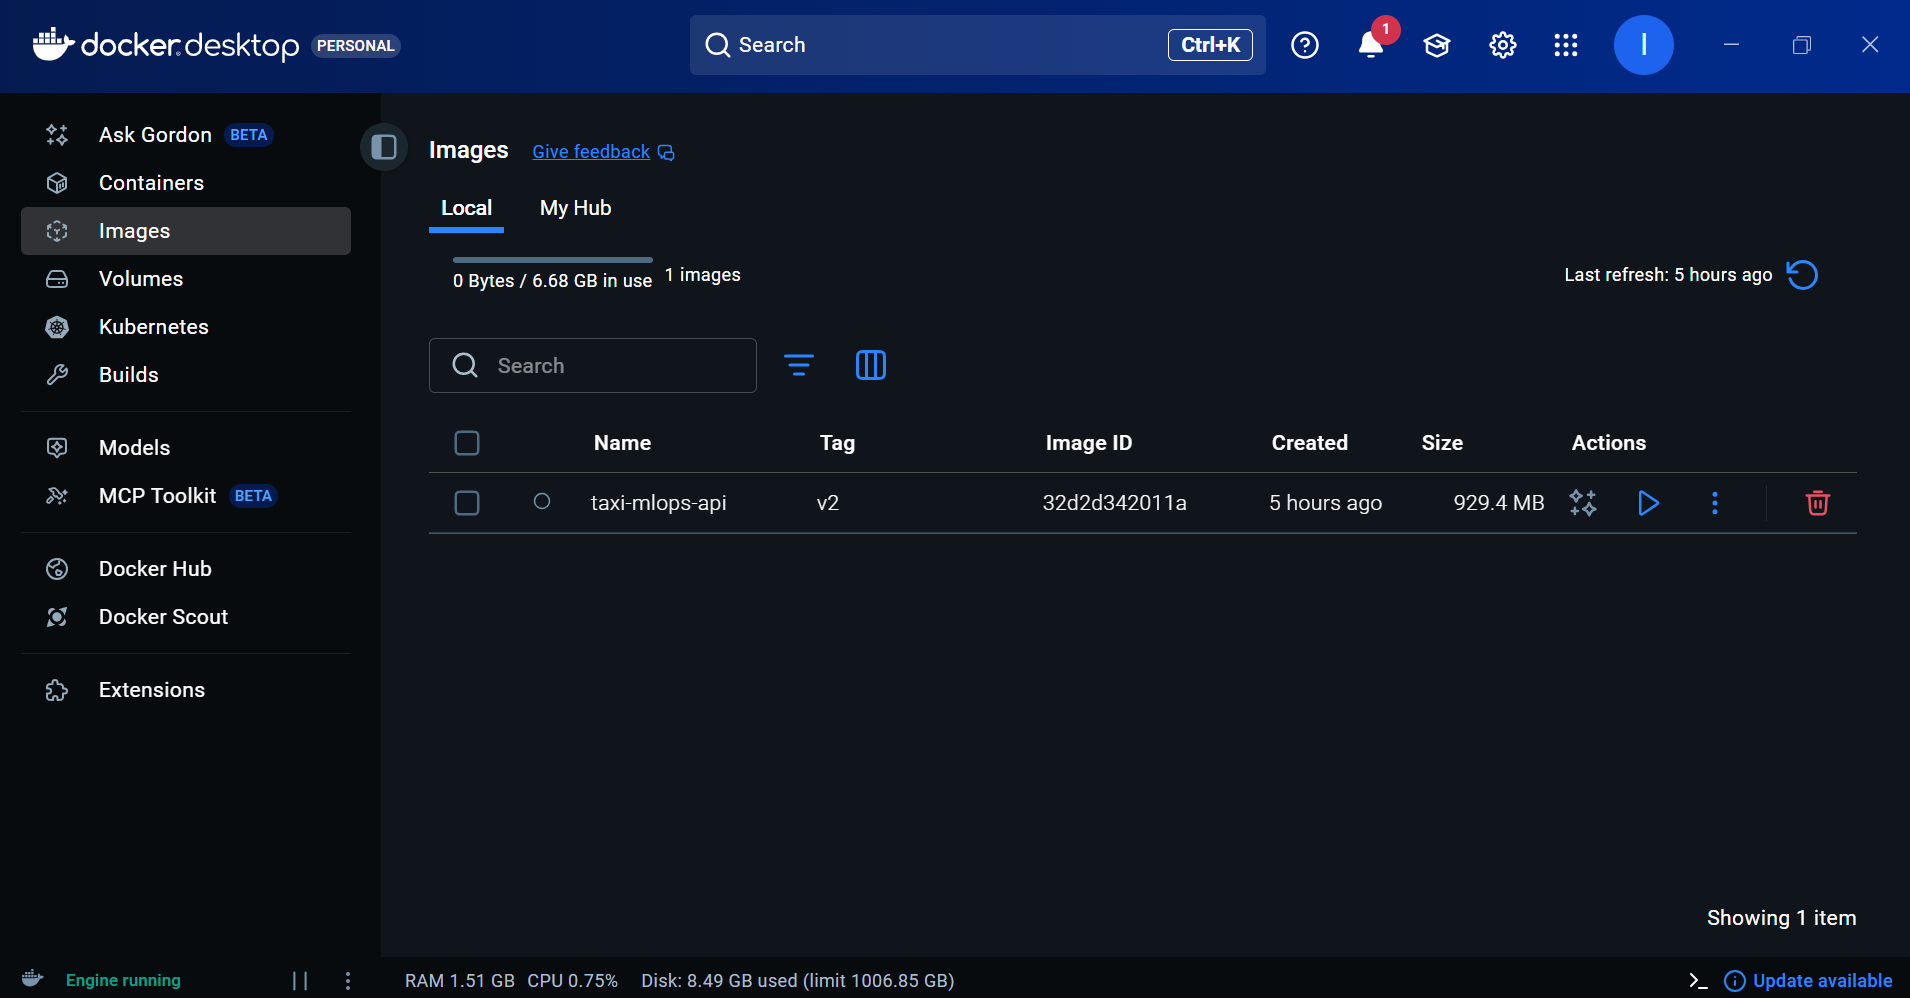

#

### **Step 7: Deploying the API to Cloud Run**

#### **7.1: Create Container in Artificat Registry**

After validating the Docker image locally, the next step was to prepare Google Cloud to store and manage my production container images.  
For this, I used **Artifact Registry**, which is Google Cloud’s secure and fully managed container registry. Before deploying to Cloud Run, the Docker image must be stored in a central, secure, versioned repository.  Artifact Registry provides:

- Versioning of images (v1, v2, etc.)  
- High-speed integration with Cloud Run  
- IAM-based access control  
- Regional storage for lower latency and cost  
- A unified place to manage deployment artifacts  

This step is essential in a real MLOps pipeline because it establishes secure, consistent image management before moving to production deployment.

In [ ]:
gcloud config set project ml-ai-portfolio

Create:
gcloud artifacts repositories create mlops-api-repo \
 --repository-format=docker \
 --location=northamerica-northeast2 \
 --description="Repository for Taxi Forecasting API"

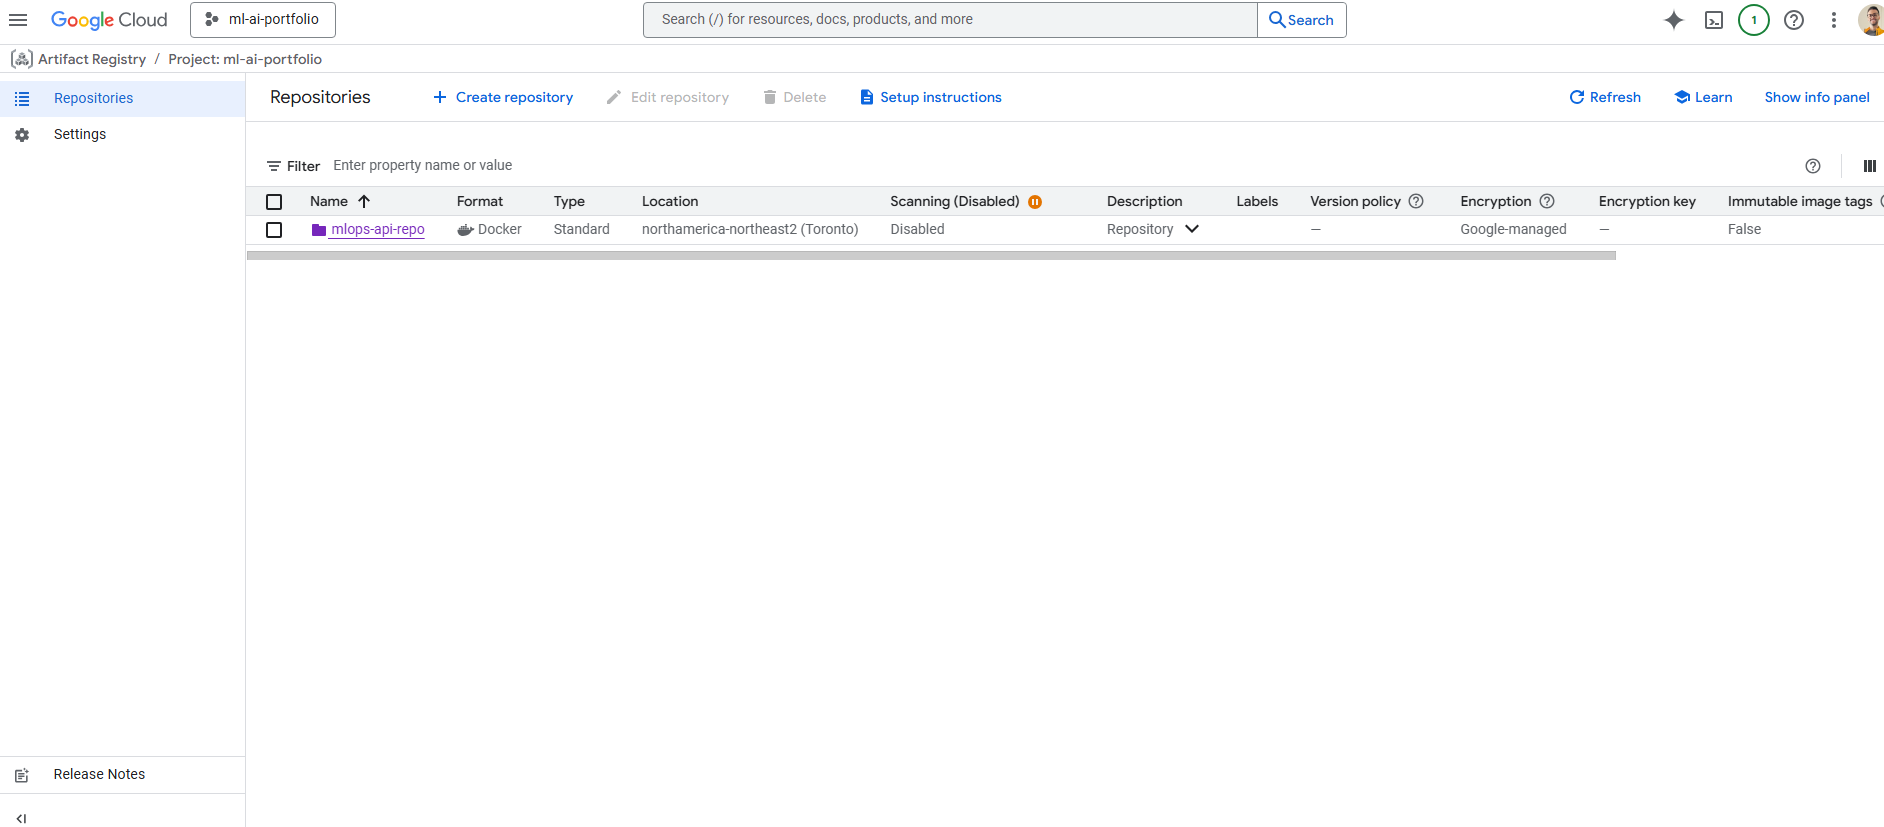

#### **7.2: Build and Push Images to Cloud Run**

After the Docker image was successfully pushed to Artifact Registry, the final stage of deployment was to turn it into a fully managed, production-grade web service using **Cloud Run**.

Cloud Run is the execution environment that hosts the FastAPI application and exposes it securely over HTTPS.  At this point in the workflow, everything was ready for deployment:
- The FastAPI application was fully implemented  
- The Dockerfile was tested and validated locally  
- The container image was stored and versioned in Artifact Registry  

During deployment, Cloud Run automatically:
- Pulled the image from Artifact Registry  
- Created a fully serverless container instance  
- Configured autoscaling (scale-to-zero included)  
- Provisioned a secure HTTPS endpoint  
- Connected the service to Google Cloud IAM  

Once deployed, Cloud Run provided:
- A public HTTPS URL for the FastAPI service  
- Automatic SSL/TLS certificates  
- Scalable, pay-per-use infrastructure  
- System health checks  
- Logging and monitoring via Cloud Logging & Cloud Trace  

At this point, the entire system was live and accessible. The same forecasting logic that originated in BigQuery ML — and was wrapped into a clean Python inference layer — was now available as a fully managed API endpoint.


In [ ]:
# Build Local Image
docker build -t taxi-mlops-api:v1 .

# Tag Image
docker tag taxi-mlops-api:v1 \
northamerica-northeast2-docker.pkg.dev/ml-ai-portfolio/mlops-api-repo/taxi-mlops-api:v1

# Push Image
docker push northamerica-northeast2-docker.pkg.dev/ml-ai-portfolio/mlops-api-repo/taxi-mlops-api:v1

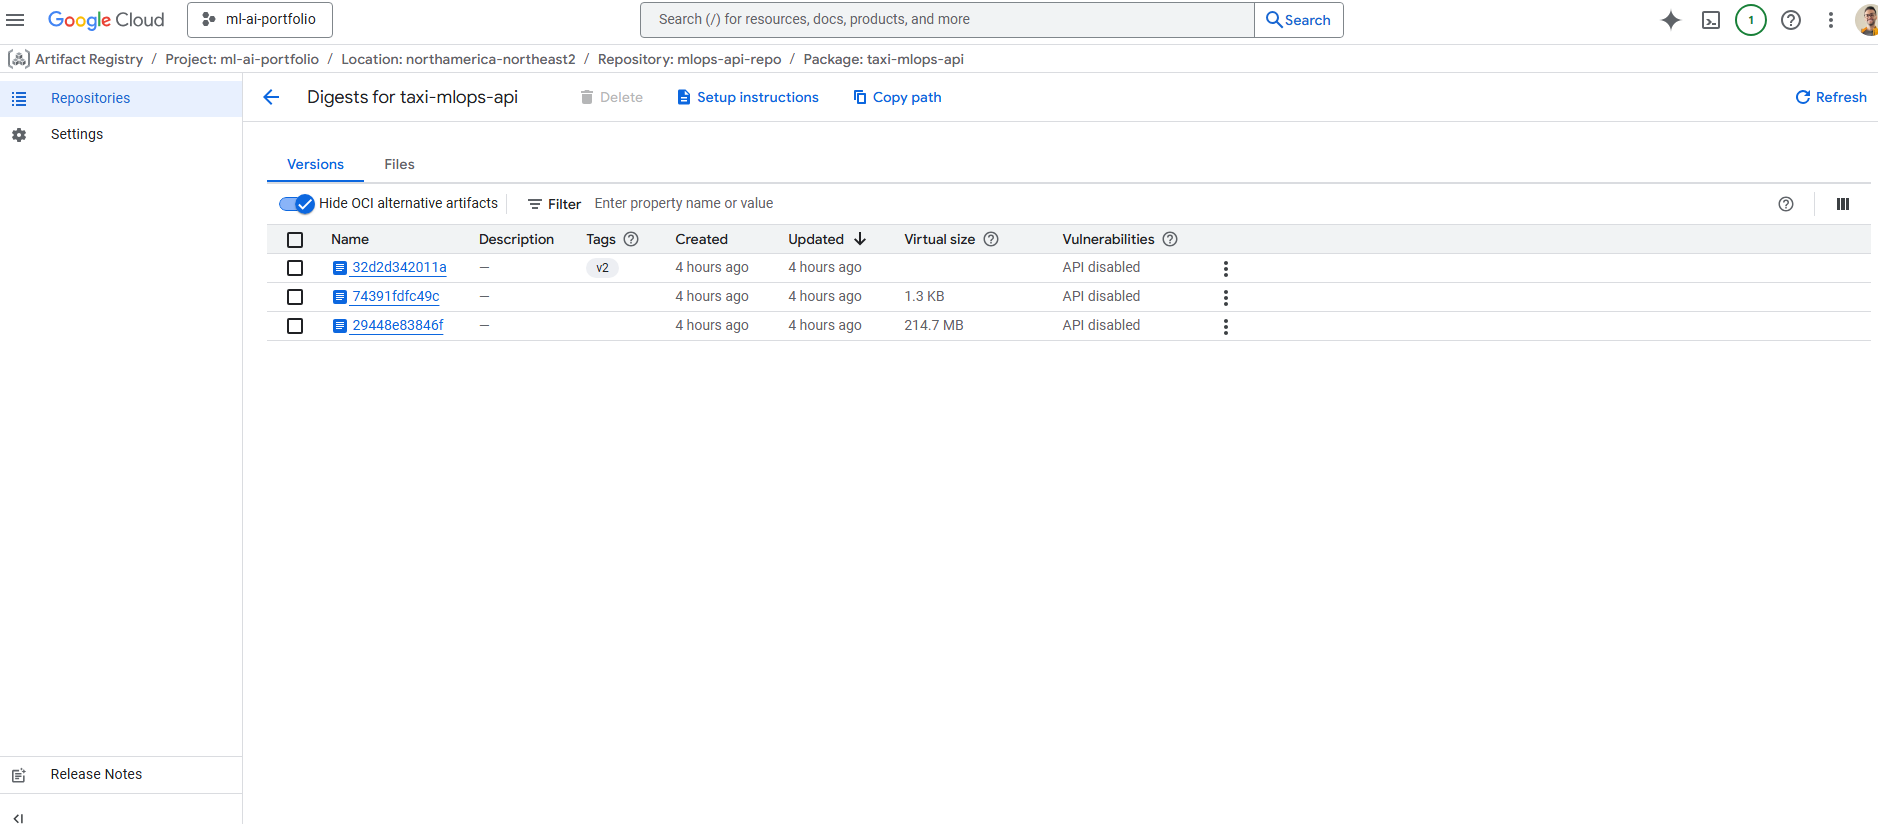

After pushing the Docker image to Artifact Registry, the final step was to deploy it as a production-ready API service using **Google Cloud Run**. Cloud Run is a fully managed serverless platform, meaning Google Cloud automatically handles:
- Scaling  
- Networking  
- Security  
- Container orchestration  

Once deployed, Cloud Run:
- Created a new service revision  
- Configured networking and IAM  
- Assigned a fully managed **HTTPS endpoint**  
- Secured it automatically with **managed TLS certificates**  

After deployment completed, the service was fully live in production.

The final result:
- The API responded correctly  
- The HTML UI loaded and interacted with the API  
- Forecasts were generated successfully  
- The service auto-scaled based on incoming traffic  


In [ ]:
gcloud run deploy taxi-mlops-api \
 --image northamerica-northeast2-docker.pkg.dev/ml-ai-portfolio/mlops-api-repo/taxi-mlops-api:v1 \
 --region northamerica-northeast2 \
 --platform managed \
 --allow-unauthenticated \
 --memory 1Gi \
 --cpu 1

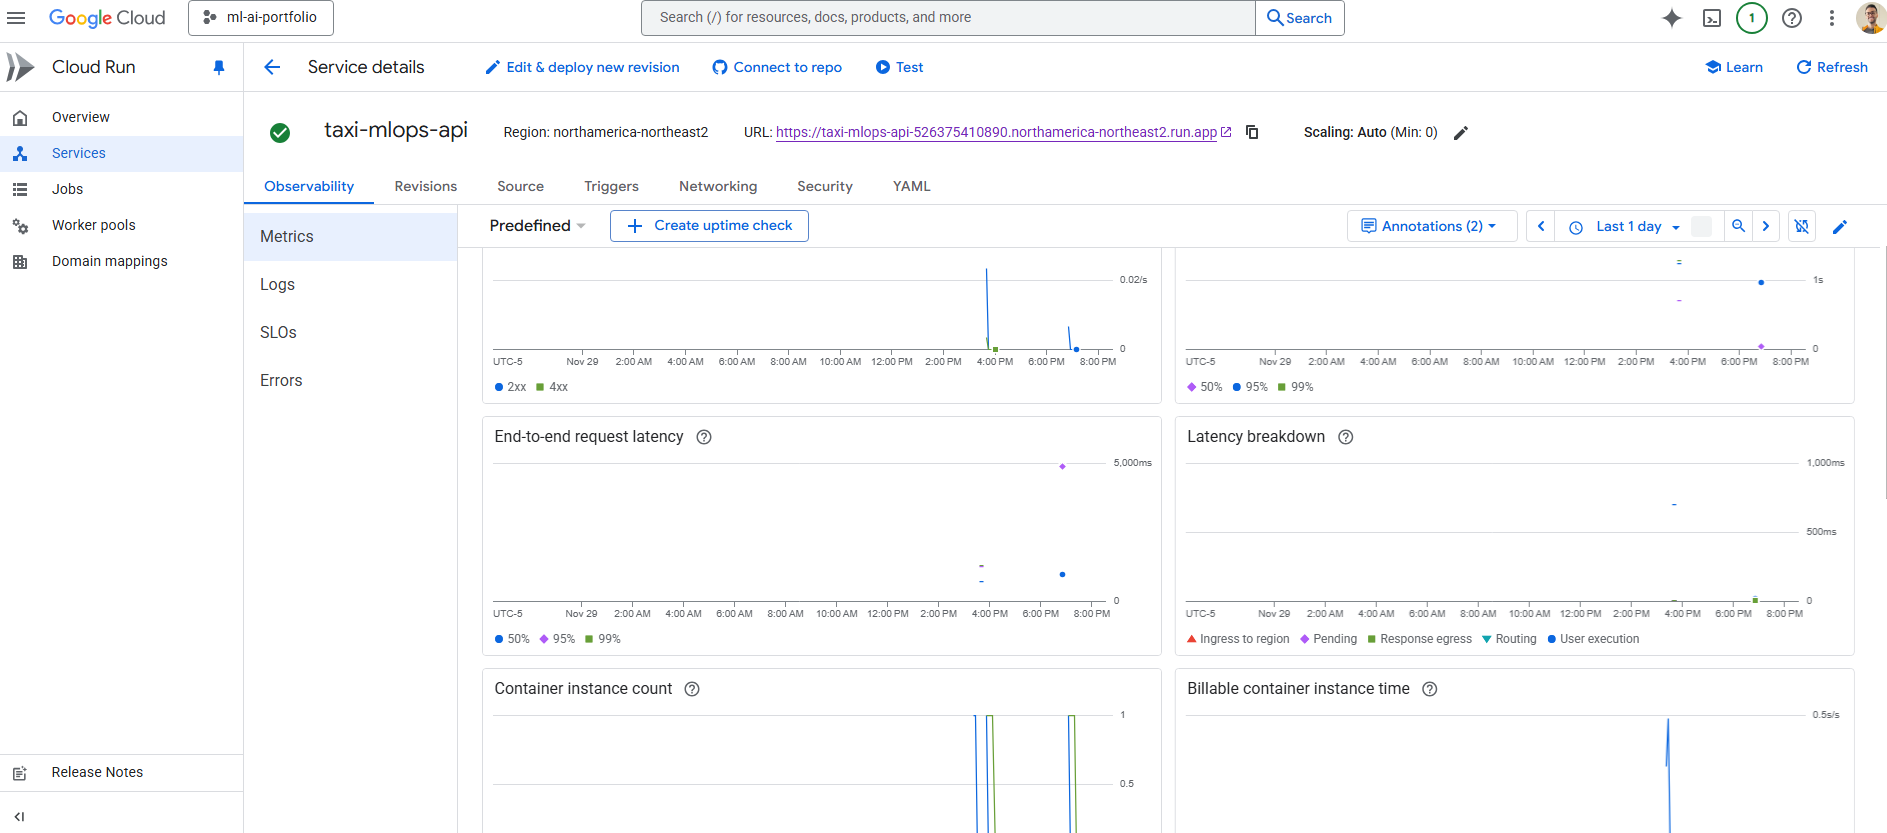

### **Summary**

This project brought together every stage of a modern MLOps workflow — from building clean business logic, designing reusable KFP pipelines, orchestrating model training in Vertex AI, and managing artifacts in Cloud Storage, all the way to packaging the model into a Dockerized FastAPI service and deploying it on Cloud Run.

By the end, the entire system became fully automated, scalable, and production-ready, turning a simple ARIMA forecasting model into a real product that users can interact with through a live API.
This wasn’t just about training a model — it was about engineering the full lifecycle: reproducibility, automation, deployment, and reliability.

The result is a complete end-to-end machine learning pipeline running seamlessly on Google Cloud, demonstrating both technical depth and real-world engineering practice.
